## Imports

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Visualizing Dataset 

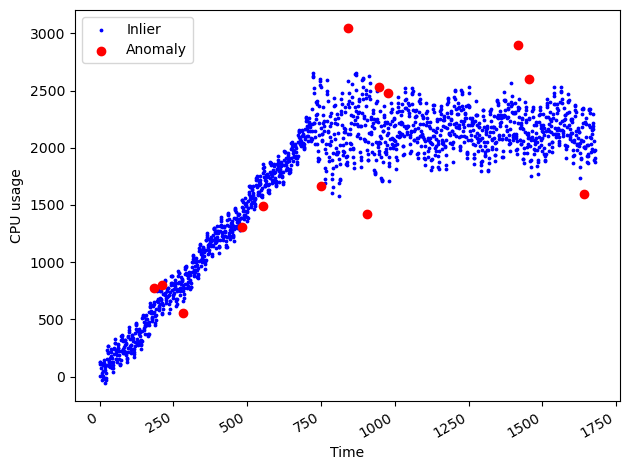

In [69]:
df = pd.read_csv("yahoo_data/A4Benchmark/A4Benchmark-TS1.csv")
anomaly_df = df.loc[df['anomaly'] == 1]
inlier_df = df.loc[df['anomaly'] == 0]

fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

## Model

In [70]:
# Functions for anomaly detection and evaluation
def sliding_window_std(df, column_name, window_size, threshold):
    results = []
    problem_vals = []  # List to store values that exceed the threshold
    problematic_rows = []  # List to store rows corresponding to problematic values
    for i in range(len(df)):
        # Calculate the window boundaries
        start_index = max(0, i - window_size // 2)
        end_index = min(len(df), i + window_size // 2 + 1)
        # Get the numbers within the window
        window = df[column_name].iloc[start_index:end_index]
        
        # Calculate the standard deviation of the window
        std_dev = window.std()
        
        # Append the result to the results list
        results.append((i, df.iloc[i][column_name], window.tolist(), std_dev))
        if len(results) >= 3:
            avg_prev_results = (results[-3][3] + results[-2][3]) / 2
            threshold_value = avg_prev_results + threshold

            if std_dev > threshold_value:
                # Append the index and value to problem_vals
                row = finding_row_number(df[column_name],  window.iloc[-1])
                problematic_row = df.iloc[row]
                
                if removing_seasonal_points(problematic_row):
                    #problem_vals.append((i - window_size // 2, window.iloc[-1]))
                    df.at[row, 'predicted_anomalies'] = 1
                else:
                    pass
    return df
                

def finding_row_number(original_lst, anomaly_lst):
    i = -1
    for num in original_lst:
        i +=1
        if num == anomaly_lst:
            return i

def removing_seasonal_points(anomalous_row):
    a=anomalous_row["timestamps"]
    dt_obj = datetime.datetime.strptime(str(a), '%Y-%m-%d %H:%M:%S')
    if dt_obj.hour== 17 or  dt_obj.hour== 5:
        return False        
    else:
        return True

df = pd.read_csv("yahoo_data/A4Benchmark/A4Benchmark-TS1.csv")
# Specify the column name containing the data
column_name = 'value'

df['timestamps'] = pd.to_datetime(df['timestamps'], unit='s')

window_size = 10
threshold = 10  # Adjust threshold as needed
df['predicted_anomalies'] = 0

df=sliding_window_std(df, column_name, window_size, threshold)
# Evaluate anomaly detection and return accuracy
#accuracy = evaluate_anomaly_detection(df['anomaly'], df['predicted_anomalies'])
#print(accuracy)

In [71]:
df.head()

,timestamps,value,anomaly,changepoint,trend,noise,seasonality1,seasonality2,seasonality3,predicted_anomalies
0,2014-11-23 06:00:00,-4.561680,0,0,2,-6.561680,0.000000,0.000000,0.000000,0
1,2014-11-23 07:00:00,168.300473,0,0,4,13.153134,99.800000,48.243870,3.103469,0
2,2014-11-23 08:00:00,312.128155,0,0,6,33.866887,172.858671,93.200000,6.202598,0
3,2014-11-23 09:00:00,326.016206,0,0,8,-22.681550,199.600000,131.804704,9.293052,0
4,2014-11-23 10:00:00,298.050665,0,0,10,-58.605649,172.858671,161.427135,12.370508,0


In [72]:
anomaly_counts = df['predicted_anomalies'].value_counts()

In [73]:
print(anomaly_counts )

predicted_anomalies
0    979
1    701
Name: count, dtype: int64


## Results

In [74]:
def evaluate_anomaly_detection(true_labels, predicted_labels):
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Extract true positives (TP) and true negatives (TN)
    TP = cm[1, 1]  # Actual positive (1) and predicted positive (1)
    TN = cm[0, 0]  # Actual negative (0) and predicted negative (0)
    FP = cm[0, 1]  # Actual negative (0) but predicted positive (1)
    FN = cm[1, 0]  # Actual positive (1) but predicted negative (0)

    # # Output true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN)
    # print("True Positives (TP):", TP)
    # print("True Negatives (TN):", TN)
    # print("False Positives (FP):", FP)
    # print("False Negatives (FN):", FN)

    # # Generate classification report
    # report = classification_report(true_labels, predicted_labels)
    # print("\nClassification Report:\n", report)

    # Calculate Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate Precision
    precision = TP / (TP + FP)

    # Calculate Recall
    recall = TP / (TP + FN)

    # Calculate F1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1_score)
    print("TP",TP)
    print("TN",TN)
    print("FP",FP)
    print("FN",FN)
    #return accuracy


In [75]:
# Evaluate anomaly detection and return accuracy
evaluate_anomaly_detection(df['anomaly'], df['predicted_anomalies'])
#print(accuracy)

Accuracy: 0.5869047619047619
Precision: 0.012838801711840228
Recall: 0.8181818181818182
F1-score: 0.02528089887640449
TP 9
TN 977
FP 692
FN 2


## Confusion Matrix

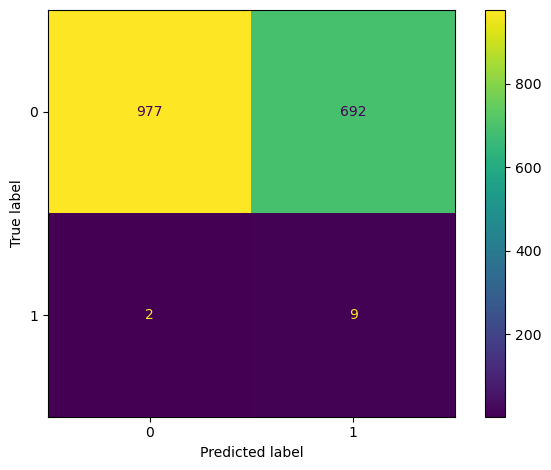

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['anomaly'], df['predicted_anomalies'], labels=[0, 1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[0, 1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

plt.savefig('confusion_matrix_yahoo.png')
plt.show()

# testing 

In [77]:
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import confusion_matrix, classification_report

# Function for anomaly detection
def sliding_window_std(df, column_name, window_size, threshold):
    results = []
    for i in range(len(df)):
        # Calculate the window boundaries
        start_index = max(0, i - window_size // 2)
        end_index = min(len(df), i + window_size // 2 + 1)
        # Get the numbers within the window
        window = df[column_name].iloc[start_index:end_index]
        
        # Calculate the standard deviation of the window
        std_dev = window.std()
        
        # Append the result to the results list
        results.append((i, df.iloc[i][column_name], window.tolist(), std_dev))
        if len(results) >= 3:
            avg_prev_results = (results[-3][3] + results[-2][3]) / 2
            threshold_value = avg_prev_results + threshold

            if std_dev > threshold_value:
                # Append the index and value to problem_vals
                row = finding_row_number(df[column_name], window.iloc[-1])
                problematic_row = df.iloc[row]
                
                if removing_seasonal_points(problematic_row):
                    df.at[row, 'predicted_anomalies'] = 1
                else:
                    pass
    return df

# Helper function to find the row number
def finding_row_number(original_lst, anomaly_lst):
    i = -1
    for num in original_lst:
        i += 1
        if num == anomaly_lst:
            return i

# Function to remove seasonal points
def removing_seasonal_points(anomalous_row):
    a = anomalous_row["timestamps"]
    dt_obj = datetime.datetime.strptime(str(a), '%Y-%m-%d %H:%M:%S')
    if dt_obj.hour == 17 or dt_obj.hour == 5:
        return False        
    else:
        return True

# Load the data
df = pd.read_csv("yahoo_data/A4Benchmark/A4Benchmark-TS32.csv")
column_name = 'value'
df['timestamps'] = pd.to_datetime(df['timestamps'], unit='s')
df['predicted_anomalies'] = 0

# Evaluate anomaly detection and return accuracy
def evaluate_anomaly_detection(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    counts = (true_labels == 1).sum()
    accuracy = TP / counts if counts > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return recall

# Grid search for the best recall
def grid_search(df, column_name, true_labels, window_sizes, thresholds):
    best_recall = 0
    best_params = (None, None)
    
    for window_size in window_sizes:
        for threshold in thresholds:
            df_copy = df.copy()
            df_copy['predicted_anomalies'] = 0
            df_copy = sliding_window_std(df_copy, column_name, window_size, threshold)
            recall = evaluate_anomaly_detection(df_copy[true_labels], df_copy['predicted_anomalies'])
            if recall > best_recall:
                best_recall = recall
                best_params = (window_size, threshold)
    
    return best_params, best_recall

# Define parameter ranges for grid search
window_sizes = range(10, 50, 5)  # Example range for window sizes
thresholds = range(10, 50, 5)  # Example range for thresholds

# Perform grid search
best_params, best_recall = grid_search(df, column_name, 'anomaly', window_sizes, thresholds)
print("Best parameters:", best_params)
print("Best recall:", best_recall)

# Final run with best parameters
best_window_size, best_threshold = best_params
df['predicted_anomalies'] = 0
df = sliding_window_std(df, column_name, best_window_size, best_threshold)

# Evaluate and print final results
recall = evaluate_anomaly_detection(df['anomaly'], df['predicted_anomalies'])
print("Final Recall:", recall)

Best parameters: (10, 10)
Best recall: 0.8181818181818182
Final Recall: 0.8181818181818182
